<a href="https://colab.research.google.com/github/davidcpage/Imagenette-experiments/blob/master/Tying_out_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of today's notebook is to setup training runs on fastai and fastai2 codebases which achieve identical results after fixing random seeds. We continue to use Nvidia DALI for dataloading.

### Setup

Install fastai2 and DALI. You may need to restart afterwards.

In [0]:
!python -m pip install typeguard
!python -m pip install --upgrade pillow fastprogress
!python -m pip install git+https://github.com/fastai/fastai2
!python -m pip install --extra-index-url https://developer.download.nvidia.com/compute/redist/cuda/10.0 nvidia-dali

RANGER = 'https://raw.githubusercontent.com/lessw2020/Ranger-Mish-ImageWoof-5/master/ranger.py'
UTILS = 'https://raw.githubusercontent.com/davidcpage/Imagenette-experiments/master/utils.py'
!wget $RANGER -O ranger.py
!wget $UTILS -O utils.py

### Main

Imports, device setup and dataset download:

In [0]:
from functools import partial
import numpy as np
import torch
import torch.nn as nn
import fastai, fastai.vision
import fastai2, fastai2.callback.all

import ranger
from utils import *


data_dir = fastai.datasets.untar_data(fastai.datasets.URLs.IMAGENETTE_160)
device = torch.device(torch.cuda.current_device())

torch.backends.cudnn.benchmark = True

Today is about being deterministic:

In [0]:
torch.backends.cudnn.deterministic = True

DALI DataLoaders

In [0]:
size = 128
bs = 64
random_aspect_ratio = (3/4, 4/3)
random_area = (0.35, 1.)
val_xtra_size = 32

to = lambda dtype: (lambda b: (b[0].to(dtype), b[1]))

train_dl = lambda folder, bs, dtype=torch.float16, seed=-1: (
        Map(to(dtype), DALIDataLoader(imagenet_train_graph(folder, size, random_aspect_ratio, random_area), bs, drop_last=True, device=device, seed=seed)))
valid_dl = lambda folder, bs, dtype=torch.float16: Chain(
        Map(to(dtype), DALIDataLoader(imagenet_valid_graph(folder, size, val_xtra_size), bs, drop_last=False, device=device)),
        Map(to(dtype), DALIDataLoader(imagenet_valid_graph(folder, size, val_xtra_size, mirror=1), bs, drop_last=False, device=device)),
    )

data_v1 = lambda data_dir=data_dir, bs=bs, dtype=torch.float16, seed=-1: MockV1DataBunch(train_dl(data_dir/'train', bs, dtype, seed), valid_dl(data_dir/'val', bs, dtype))
data_v2 = lambda data_dir=data_dir, bs=bs, dtype=torch.float16, seed=-1: fastai2.basics.DataBunch(train_dl(data_dir/'train', bs, dtype, seed), valid_dl(data_dir/'val', bs, dtype))

It turns out that there's a small discrepancy in cosine annealing schedules between the v1 and v2 codebases. The v2 API for param schedules (as functions on the unit interval) is nice and simple so let's add an adaptor for v1 to use this:


In [0]:
class FuncScheduler(fastai.train.LearnerCallback):
    def __init__(self, func, learn, n_epoch):
        super().__init__(learn)
        self.learn, self.func, self.n_epoch = learn, func, n_epoch
        
    def on_train_begin(self, **kwargs):
        self.step()

    def on_batch_end(self, train, **kwargs):
        if train: self.step()

    def step(self):
        if not hasattr(self, 'iter_vals'):
            n_batch = len(self.learn.data.train_dl)*self.n_epoch 
            self.iter_vals = iter(self.func(x/n_batch) for x in range(0, n_batch+1))
        self.learn.opt.set_stat('lr', next(self.iter_vals))

def flat_then_cosine_sched(learn, n_epoch, lr, pct_start, div_final=1e5):
    func = fastai2.callback.schedule.combined_cos(pct_start, lr, lr, lr/div_final)
    return FuncScheduler(func, learn, n_epoch)

Ok, ready to go. Here's our model from last time:


In [0]:
model_fn = partial(xresnet18, c_out=10, sa=1, sym=0, act_cls=MishJit)

a v1 learner:

In [0]:
learner_v1 = partial(
    fastai.basic_train.Learner, 
    wd=1e-2, bn_wd=False, true_wd=True,
    opt_func=partial(ranger.Ranger, betas=(0.95, 0.99), eps=1e-6),
    metrics=(fastai.metrics.accuracy,),
    loss_func=fastai.layers.LabelSmoothingCrossEntropy())

and training code:

In [7]:
torch.manual_seed(123)
learn = learner_v1(data_v1(seed=123, dtype=torch.float), model_fn())
n_epoch = 5
learn.fit(n_epoch, callbacks=[flat_then_cosine_sched(learn, n_epoch, lr=4e-3, pct_start=0.72)])

epoch,train_loss,valid_loss,accuracy,time
0,1.477235,1.506388,0.601000,00:16
1,1.224201,1.079142,0.765000,00:15
2,1.111008,1.079000,0.772000,00:15
3,1.032655,0.973072,0.812000,00:15
4,0.928292,0.865962,0.868000,00:15


Now for v2, here's the learner from last time:


In [0]:
RangerWrapper = lambda *args, **kwargs: fastai2.basics.OptimWrapper(ranger.Ranger(*args, **kwargs))

learner_v2 = partial(
    fastai2.basics.Learner, lr=4e-3,
    opt_func=partial(RangerWrapper, betas=(0.95, 0.99), eps=1e-6),
    metrics=(fastai2.metrics.accuracy,),
    loss_func=fastai2.basics.LabelSmoothingCrossEntropy())

In order to handle weight decay in the same way as v1 (weight decay is not applied to BatchNorm params or biases) we create the optimiser manually outside of the call to learn.fit:

In [9]:
torch.manual_seed(123)

learn = learner_v2(data_v2(dtype=torch.float, seed=123), model_fn())
skip_wd = split_params((lambda mod, name: isinstance(mod, nn.BatchNorm2d) or name=='bias'), learn.model)
learn.opt = learn.opt_func([{'params': skip_wd[False]}, {'params': skip_wd[True]}], lr=4e-3)

learn.fit_flat_cos(5, lr=4e-3, wd=[1e-2, 0.0], pct_start=0.72)

epoch,train_loss,valid_loss,accuracy,time
0,1.477165,1.506689,0.599000,00:15
1,1.224083,1.079232,0.768000,00:15
2,1.111179,1.076746,0.774000,00:15
3,1.032706,0.971359,0.813000,00:15
4,0.928698,0.865830,0.869000,00:15


Not bad! We're getting agreement in the first 2-3 dps of train_loss with the v1 code above. The main remaining difference is the code used to apply weight decay inside the Ranger optimiser. We can get (hack) around this as by applying weight decay ourselves outside the optimiser:

In [0]:
class WeightDecay(fastai2.learner.Callback):
    def __init__(self, params, wd):
        stepper = lambda p, wd: fastai2.basics.weight_decay(p, self.opt.hypers[0]['lr'], wd)
        self.step = fastai2.basics.Optimizer(params, [stepper], wd=wd).step
        
    def after_backward(self):
        self.step()

In [11]:
torch.manual_seed(123)

learn = learner_v2(data_v2(dtype=torch.float, seed=123), model_fn())
skip_wd = split_params((lambda mod, name: isinstance(mod, nn.BatchNorm2d) or name=='bias'), learn.model)
learn.fit_flat_cos(5, lr=4e-3, wd=0.0, pct_start=0.72, cbs=[WeightDecay(skip_wd[False], 1e-2)])

epoch,train_loss,valid_loss,accuracy,time
0,1.477233,1.506388,0.601000,00:15
1,1.224201,1.079142,0.765000,00:15
2,1.111007,1.079000,0.772000,00:15
3,1.032653,0.973072,0.812000,00:15
4,0.928291,0.865962,0.868000,00:15


These agree with the v1 results to 5 dps.

### Manual training loop

In case it's useful, here's a manual training loop based somewhat loosely on the v1 codebase which also ties out to 5dp. This may be helpful for future comparison/debugging:

In [0]:
update = lambda metric, output, target: metric.on_batch_end(output, target)

format_str = lambda name, stat: (
    fastai.basic_train.format_time(stat) if 'time' in name 
    else '#na#' if stat is None 
    else str(stat) if isinstance(stat, int) 
    else f'{stat:.6f}'
)
       
def fit(learn, n_epoch, lr_sched):
    learn.create_opt(0, learn.wd)
    pbar = fastai.basics.master_bar(range(n_epoch))
    smoothener = fastai.basics.SmoothenValue(0.98)
    def valid_loss(output, target): return learn.loss_func(output, target)
    metrics = [fastai.basics.AverageMetric(m) for m in ([valid_loss] + learn.metrics)]
    names = ['epoch', 'train_loss'] + [m.name for m in metrics] + ['time']
    pbar.write(names, table=True)

    timer, logs = Timer(), []
    for epoch in pbar:
        learn.model.train()
        num_batch = 0 
        for met in metrics: met.val, met.count = 0., 0 
        for xb,yb in fastai.basics.progress_bar(learn.data.train_dl, parent=pbar):
            lr_sched.step()
            output = learn.model(xb)
            loss = learn.loss_func(output, yb)
            smoothener.add_value(loss.item())
            pbar.child.comment = f'{smoothener.smooth:.4f}'
            logs.append({'lr': learn.opt.lr, 'mom': learn.opt.mom, 'loss': smoothener.smooth})
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()
            num_batch += 1

        learn.model.eval()
        with torch.no_grad():
            for xb, yb in fastai.basics.progress_bar(learn.data.valid_dl, parent=pbar):
                output = learn.model(xb)
                for met in metrics: update(met, output, yb)

        summary = union(
            {'epoch': epoch, 'num_batch': num_batch, 'train_loss': smoothener.smooth,  'time': timer()},
            {m.name: (m.val/m.count).item() for m in metrics}
        )
        logs.append(summary)
        pbar.write([format_str(k, summary[k]) for k in names], table=True)

    return group_by_key(((k,v) for entry in logs for (k,v) in entry.items()), np.array)

In [13]:
torch.manual_seed(123)
learn = learner_v1(data_v1(seed=123, dtype=torch.float), model_fn())
n_epoch = 5
logs = fit(learn, n_epoch, flat_then_cosine_sched(learn, n_epoch, lr=4e-3, pct_start=0.72))

epoch,train_loss,valid_loss,accuracy,time
0,1.477233,1.506388,0.601000,00:15
1,1.224201,1.079142,0.765000,00:15
2,1.111007,1.079000,0.772000,00:15
3,1.032654,0.973072,0.812000,00:15
4,0.928292,0.865962,0.868000,00:15


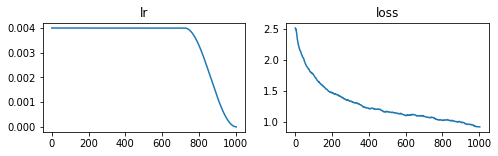

In [17]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
for ax, k in zip(axs, ['lr', 'loss']):
    ax.plot(logs[k])
    ax.set_title(k)